## Human Developmental Heart
**Date** : 2021-10-05<br>
**Author** : Alma Andersson<br>
**Description** : This notebook outlines the analysis related to the human developmental heart data.

Load necessary packages

In [340]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

import eggplant as eg

    
import os.path as osp
import os
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define paths and directories to save results

In [341]:
SAVE_MODE = False
MAIN_DIR = "../data/human-developmental-heart"
CNT_PTHS = ["curated/V10F24-105_A1.h5ad",
            "curated/V10F24-105_B1.h5ad",
            "curated/V10F24-105_C1.h5ad",
            "curated/V10F24-105_D1.h5ad",
            "curated/V10B01-014_A1.h5ad",
            "curated/V10S28-368_D1.h5ad",
            "curated/V10S28-371_A1.h5ad",
            
           ]
CNT_PTHS = [osp.join(MAIN_DIR,p) for p in CNT_PTHS]

REF_DIR = osp.join(MAIN_DIR,"references")

VAL_RES_DIR = "../../res/analysis/human-developmental-heart/"
IMG_RES_DIR = "../../res/analysis/human-developmental-heart/images"


Specify genes to transfer to the reference

In [342]:
GENES = ["MYH6","ELN","MYH7","COL2A1"]

Load and inspect the reference and its landmarks

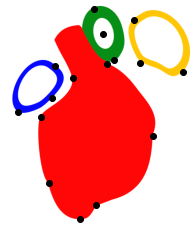

In [343]:
ref_img = Image.open(osp.join(REF_DIR,"reference.png"))
ref_lmk = pd.read_csv(osp.join(REF_DIR,"landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_coord,ref_lmk.y_coord,c = "black")
plt.axis("off")
plt.show()

Create a grid from the reference

In [344]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                       n_approx_points=10000,
                                       n_regions=4,
                                       background_color = "white",
                                      )

Inspect the generated reference grid to make sure everything looks as expected. We also specify the region colors in `mta_cmap` below.

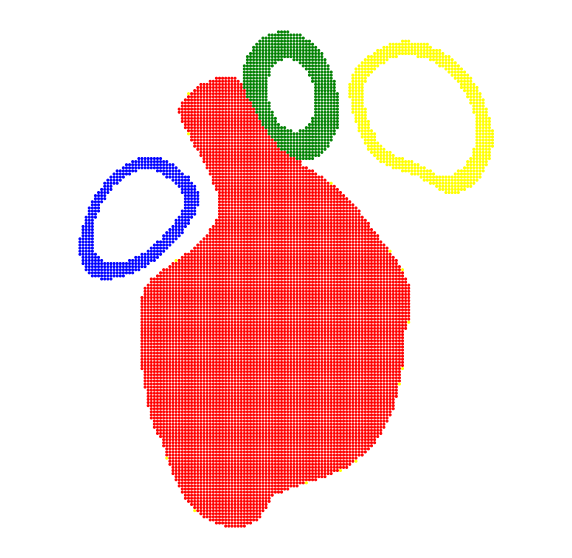

In [345]:
mta_cmap = {0:"red",1:"green",2:"yellow",3:"blue"}
plt.figure(figsize=(10,10),facecolor ="white")
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c = [mta_cmap[x] for x in mta],s = 4)

plt.axis("equal")
plt.axis("off")

plt.gca().invert_yaxis()
plt.show()

Create reference object

In [346]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                     meta = dict(region = mta),
                    )

Load observed data (`AnnData` objects)

In [347]:
adatas = [ad.read_h5ad(p) for p in CNT_PTHS]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Print loaded `AnnData` objects to make sure the data looks as expected

In [348]:
for a in adatas:
    print(a)

AnnData object with n_obs × n_vars = 2169 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2246 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2250 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2513 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'


Add **individual** information to the meta data and assign sample names

In [349]:
adatas = {f"dh{l}":adatas[k] for k,l in enumerate(["A","B","C","D","E","F","G"])}

for sample in ["A","B","C","D"]:
    adatas[f"dh{sample}"].uns["meta"]  = {"individual" : 0}
for sample in ["E","F","G"]:
    adatas[f"dh{sample}"].uns["meta"] = {"individual" : 1}

Add info the the landmarks

In [350]:
columns = ["x_coord","y_coord"]
for key in adatas.keys():
    n_lmk_a = adatas[key].uns["curated_landmarks"].shape[0]
    index = [f"Landmark_{k}" for k in range(n_lmk_a)]
    adatas[key].uns["curated_landmarks"] = pd.DataFrame(adatas[key].uns["curated_landmarks"],
                                                       columns = columns,
                                                        index = index,
                                                       )

Preprocess data

In [351]:
for adata in adatas.values():
    eg.pp.default_normalization(adata)
    eg.pp.match_scales(adata,ref)
    eg.pp.get_landmark_distance(adata,
                                reference=ref)



/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable name

Visualize the results (note this is made for figure generation, better representations from an "inspection" viewpoint can be made)

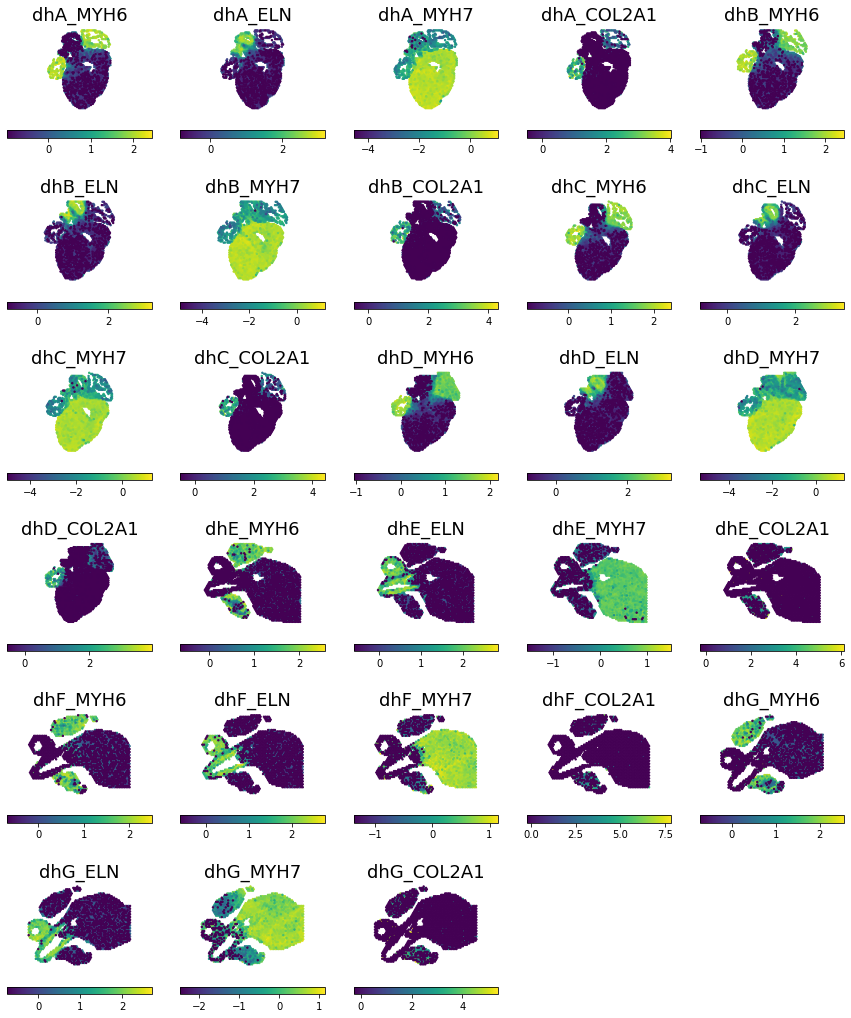

In [352]:
fig,_ = eg.pl.visualize_observed(adatas,
                         n_cols = len(GENES) +1,
                         features = GENES,
                         side_size = 3,
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = False,
                         marker_size = 2,
                         include_colorbar = True,
                         separate_colorbar = False,
                         share_colorscale = False,
                         fontsize = 18,
                         colorbar_fontsize = 10,
                         hspace = 0.4,
                         return_figures = True,
                         )

if SAVE_MODE: fig.savefig(osp.join(IMG_RES_DIR,"supp","dh-allcombs-obs.png"),bbox_inches="tight")

Transfer data to reference

In [ ]:
np.random.seed(1337)

losses = eg.fun.transfer_to_reference(adatas,
                                      GENES,
                                      ref,
                                      n_epochs=1000,
                                      device ="gpu",
                                      verbose = True,
                                      return_losses = True,
                                      return_models =False,
                                      max_cg_iterations = 10000,
                                      )

[Processing] ::  Model : dhA | Feature : MYH6 | Transfer : 1/28


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11],

Inspect the loss curves

In [ ]:
eg.pl.model_diagnostics(losses = losses)

Visualize the transferred data

In [ ]:
fig,ax = eg.pl.visualize_transfer(ref,
                         n_cols = 5,
                         side_size = 3,
                         attributes = list(adatas.keys()),
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = False,
                         marker_size = 2,
                         include_colorbar = True,
                         separate_colorbar = False,
                         share_colorscale = False,
                         fontsize = 18,
                         colorbar_fontsize = 10,
                         hspace = 0.4,
                         return_figures = True,
                        )

if SAVE_MODE: fig.savefig(osp.join(IMG_RES_DIR,"supp","dh-allcombs-trans.png"),bbox_inches="tight")

Generate composite representation based on the `feature`

In [ ]:
ref.composite_representation(by = "feature")

Visualize the composite representations

In [ ]:
fig,ax = eg.pl.visualize_transfer(ref,
                         n_cols = len(GENES),
                         attributes = "composite",
                         side_size = 4.2,
                         wspace = 0.1,
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = False,
                         marker_size = 2,
                         include_colorbar = True,
                         separate_colorbar = False,
                         share_colorscale = False,
                         fontsize = 20,
                         colorbar_fontsize = 20,
                                return_figures = True,
                        )

for axx,gene in zip(ax,["COL2A1","ELN","MYH6","MYH7"]):
    axx.set_title("Composite Profile:\n {}".format(gene),fontsize = 20)
    
if SAVE_MODE:
    fig.savefig(osp.join(IMG_RES_DIR,"main","dh-composite.png"),bbox_inches="tight")

Assess regional enrichment

In [ ]:
outside = {"attribute":"var","column":"feature"}
inside = {"attribute":"obs","column":"region"}
fig,ax = eg.pl.distplot_transfer(ref,
                       inside,
                       outside,
                       return_figure=True,
                       n_cols = 2,
                       ticks_fontsize = 15,
                       title_fontsize = 20,
                       side_size = 2.5,
                       mean_marker_style={"c":"red","s":70,"marker":"o"}
                    )

for k,axx in enumerate(ax):
    axx.set_ylabel("")
    axx.set_xlabel("Region")#,fontsize = )


### Statistical Test of COL2A1 left-right asymmetry

test whether there is a statistically significant assymetry present in the expression of *COL2A1* between region 2 and 3.

In [ ]:
region_1 = 3
region_2 = 2
feature = "COL2A1"
assymetry_test = eg.sdea.test_region_wise_enrichment(data = ref,
                                            feature = feature,
                                            region_1= region_1,
                                            region_2= region_2,
                                            include_models = "composite",
                                            col_name = "region",
                                            feature_col = "feature",
                                            alpha = 0.05,
                                            n_permutations = 1000,
                                            )

In [ ]:
if assymetry_test["composite"]["is_sig"]:
    test_msg = "has"
else:
    test_msg = "does not have "

print(f"{feature} {test_msg} a statistically significant different expression betweeen region {region_1} and region {region_2}")

## Sample Correlation

Assess the inter-individual and intra-individual patient correlation in the reference domain.

In [ ]:
_adata = ref.adata
corr_res = dict()
for gene in GENES:
    g_a = _adata[:, (_adata.var["model"].values != "composite") & (_adata.var["feature"].values == gene)]
    n = g_a.shape[1]
    corrcoef = np.corrcoef(np.array(g_a.X).T)
    triu = np.triu_indices_from(corrcoef,k=1)
    corrcoef[triu] = 0
    names = g_a.var["model"].values
    corr_res[gene] = [corrcoef,names] 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
side_size = 5
tick_fontsize = 15
n_cols = len(GENES) / 2
n_rows = 2

fig,ax = plt.subplots(int(n_rows),int(n_cols),
                      figsize = (side_size * n_cols, side_size * n_rows),
                     )
ax = ax.flatten()


for k,gene in enumerate(GENES):
    im = ax[k].imshow(corr_res[gene][0],
                cmap = plt.cm.RdBu_r,
                vmin=-1,vmax = 1,  
                     )
    
    n_samples = corr_res[gene][0].shape[0]
    ax[k].set_xticks(np.arange(n_samples))
    ax[k].set_xticklabels(corr_res[gene][1],rotation = 90,fontsize = tick_fontsize)
    ax[k].set_yticks(np.arange(n_samples))
    ax[k].set_yticklabels(corr_res[gene][1],fontsize = tick_fontsize)
    ax[k].set_title(gene, fontsize = 20)
    ax[k].spines["right"].set_visible(False)
    ax[k].spines["top"].set_visible(False)

    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    

    cbar = fig.colorbar(im,cax = cax)
    
fig.subplots_adjust(wspace = 0.5)
if SAVE_MODE: fig.savefig(osp.join(IMG_RES_DIR,"supp","dh-corr.png"))

compute correlation between individuals

In [ ]:
def individual_corr(adata: ad.AnnData,
                    corr_res: dict,
                    index0: int = 0,
                    index1: int = 1,
                   ):
    ind0 = np.unique(adata[:,adata.var["individual"].values == index0].var["model"])
    ind1 = np.unique(adata[:,adata.var["individual"].values == index1].var["model"])
    sum_corr = 0
    n_comps = 0
    
    for k,gene in enumerate(corr_res.keys()):
        _rs,_names = corr_res[gene]
        for i0 in ind0:
            v0 = int(np.argmax(_names == i0))
            for i1 in ind1:
                if i1 != i0:
                    v1 = int(np.argmax(_names == i1))
                    sum_corr += _rs[max(v1,v0),min(v1,v0)]
                    n_comps += 1


    av_corr = sum_corr / n_comps
    return av_corr

individual_corr_res = dict()
for ii in [0,1]:
    for jj in [0,1]:
        name = "ind{}_vs_ind{}".format(*sorted([ii+1,jj+1]))
        if name not in individual_corr_res.keys():
            individual_corr_res[name] = round(individual_corr(_adata,corr_res,ii,jj),2)

save correlation results

In [ ]:
if SAVE_MODE:
    for k,v in individual_corr_res.items():
        with open(osp.join(VAL_RES_DIR,"corrs",f"{k}.dat"),"w+") as f:
            f.write(str(v))